<a href="https://colab.research.google.com/github/JesseChildress/Mental_Health_in_Tech/blob/main/Mental_Health_in_Tech_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [656]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, silhouette_score, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler,  LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
#First Choice Data Set
df = pd.read_csv('/content/Mental Health in Tech.csv')
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [556]:
#checking missing values, dtypes, number of columns and rows, etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [557]:
#deleted duplicate rows
df.duplicated().sum()


0

No Duplicates

In [558]:
#deleted unnecessary columns
#this column will have no effect on the outcome
del df['Timestamp']
#this column will have no effect on the outcome
del df['comments']
#While this column could have some relevance, it is likely to be minimal and nearly half the values are missing anyway
del df['state']
#Most are from the US; the few outliers are likely to have little effect on the overall analysis
del df['Country']

In [559]:
#identified and addressed missing values : work_interfere, self_employed
#I'm going to fill both columns with "Unknown" so that we can use that data but the data
#for these columns won't skew the data
df['work_interfere'].fillna("Unknown", inplace = True)
df['self_employed'].fillna("Unknown", inplace = True)

In [560]:
#confirming all values filled in 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        1259 non-null   int64 
 1   Gender                     1259 non-null   object
 2   self_employed              1259 non-null   object
 3   family_history             1259 non-null   object
 4   treatment                  1259 non-null   object
 5   work_interfere             1259 non-null   object
 6   no_employees               1259 non-null   object
 7   remote_work                1259 non-null   object
 8   tech_company               1259 non-null   object
 9   benefits                   1259 non-null   object
 10  care_options               1259 non-null   object
 11  wellness_program           1259 non-null   object
 12  seek_help                  1259 non-null   object
 13  anonymity                  1259 non-null   object
 14  leave   

In [561]:
#identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats)
print(df['Gender'].value_counts())
print(df['self_employed'].value_counts())
print(df['family_history'].value_counts())
print(df['treatment'].value_counts())
print(df['work_interfere'].value_counts())
print(df['no_employees'].value_counts())
print(df['remote_work'].value_counts())
print(df['tech_company'].value_counts())
print(df['benefits'].value_counts())
print(df['care_options'].value_counts())
print(df['wellness_program'].value_counts())
print(df['seek_help'].value_counts())
print(df['anonymity'].value_counts())
print(df['leave'].value_counts())
print(df['mental_health_consequence'].value_counts())
print(df['coworkers'].value_counts())
print(df['supervisor'].value_counts())
print(df['mental_health_interview'].value_counts())
print(df['phys_health_consequence'].value_counts())
print(df['phys_health_interview'].value_counts())
print(df['mental_vs_physical'].value_counts())
print(df['obs_consequence'].value_counts())


Male                                              615
male                                              206
Female                                            121
M                                                 116
female                                             62
F                                                  38
m                                                  34
f                                                  15
Make                                                4
Woman                                               3
Male                                                3
Man                                                 2
Female (trans)                                      2
Cis Male                                            2
Female                                              2
Guy (-ish) ^_^                                      1
Mail                                                1
male leaning androgynous                            1
queer                       

The Only column with inconsistencies is 'Gender'. I will address inconsistencies by putting anything that evidently should be "Male" or "Female" into those categories, and add others that are unclear or non-traditional into a third, "other" category. While this will not represent the divesity of gender identities it will be a way to get a reasonable sample size that represents a different experience other than either identifying as male or female

In [562]:
df['Gender'].str.strip()


0       Female
1            M
2         Male
3         Male
4         Male
         ...  
1254      male
1255      Male
1256      male
1257         f
1258      Male
Name: Gender, Length: 1259, dtype: object

In [563]:
df['Gender'].replace(to_replace = 'female', value = 'Female', inplace = True)
df['Gender'].replace(to_replace = 'F', value = 'Female', inplace = True)
df['Gender'].replace(to_replace = 'f', value = 'Female', inplace = True)
df['Gender'].replace(to_replace = 'Woman', value = 'Female', inplace = True)
df['Gender'].replace(to_replace = 'Female ', value = 'Female', inplace = True)
df['Gender'].replace(to_replace = 'male', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'M', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'm', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'Make', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'Male ', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'Cis Male', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'Man', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'Male-ish', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'Guy (-ish) ^_^', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'something kinda male?', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'Cis Female', value = 'Female', inplace = True)
df['Gender'].replace(to_replace = 'msle', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'maile', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'Mal', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'ostensibly male, unsure what that really means', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'cis male', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'Malr', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'male leaning androgynous', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'Cis Man', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'Mail', value = 'Male', inplace = True)
df['Gender'].replace(to_replace = 'Female (trans)', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'Female (cis)', value = 'Female', inplace = True)
df['Gender'].replace(to_replace = 'cis-female/femme', value = 'Female', inplace = True)
df['Gender'].replace(to_replace = 'femail', value = 'Female', inplace = True)
df['Gender'].replace(to_replace = 'Femake', value = 'Female', inplace = True)
df['Gender'].replace(to_replace = 'woman', value = 'Female', inplace = True)
df['Gender'].replace(to_replace = 'non-binary', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'Genderqueer', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'queer', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'Trans-female', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'Neuter', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'Androgyne', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'p', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'A little about you', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'Agender', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'fluid', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'Nah', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'Trans woman', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'queer/she/they', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'All', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'Enby', value = 'Other', inplace = True)
df['Gender'].replace(to_replace = 'Male (CIS)', value = 'Other', inplace = True)


print(df['Gender'].value_counts())


Male      994
Female    247
Other      18
Name: Gender, dtype: int64


In [564]:
#checking 'Age' to make sure the inputs are all good
df['Age'].value_counts()

 29             85
 32             82
 26             75
 27             71
 33             70
 28             68
 31             67
 34             65
 30             63
 25             61
 35             55
 23             51
 24             46
 37             43
 38             39
 36             37
 39             33
 40             33
 43             28
 41             21
 22             21
 42             20
 21             16
 45             12
 46             12
 44             11
 19              9
 18              7
 20              6
 48              6
 50              6
 51              5
 56              4
 49              4
 57              3
 54              3
 55              3
 47              2
 60              2
 11              1
 8               1
 5               1
 99999999999     1
-1726            1
 53              1
 58              1
 61              1
 62              1
 65              1
 72              1
 329             1
-29              1
-1          

When I began making univariate visuals I discovered that some of the Age inputs are nonsensical. There are 8 Age inputs that are bad, I am choosing to drop those rows for two reasons: 1, it is a miniscule percentage of the overall data, 2, anyone who puts something like that for their age is less likely to have answered seriously and are likely to skew the data anyway.

In [565]:
df['Age'].replace(to_replace = -1, value = np.NaN, inplace = True)
df['Age'].replace(to_replace = -1726, value = np.NaN, inplace = True)
df['Age'].replace(to_replace = -29, value = np.NaN, inplace = True)
df['Age'].replace(to_replace = 329, value = np.NaN, inplace = True)
df['Age'].replace(to_replace = 5, value = np.NaN, inplace = True)
df['Age'].replace(to_replace = 8, value = np.NaN, inplace = True)
df['Age'].replace(to_replace = 11, value = np.NaN, inplace = True)
df['Age'].replace(to_replace = 99999999999, value = np.NaN, inplace = True)


In [566]:
#looking again at date= there are now null values in 'Age', which I will drop
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        1251 non-null   float64
 1   Gender                     1259 non-null   object 
 2   self_employed              1259 non-null   object 
 3   family_history             1259 non-null   object 
 4   treatment                  1259 non-null   object 
 5   work_interfere             1259 non-null   object 
 6   no_employees               1259 non-null   object 
 7   remote_work                1259 non-null   object 
 8   tech_company               1259 non-null   object 
 9   benefits                   1259 non-null   object 
 10  care_options               1259 non-null   object 
 11  wellness_program           1259 non-null   object 
 12  seek_help                  1259 non-null   object 
 13  anonymity                  1259 non-null   objec

In [567]:
#dropping
df.dropna(0, how = 'any', inplace = True)


In [568]:
#returning age dtype to original
df['Age'] = df['Age'].astype(int)


In [569]:
#confirming the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251 entries, 0 to 1258
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        1251 non-null   int64 
 1   Gender                     1251 non-null   object
 2   self_employed              1251 non-null   object
 3   family_history             1251 non-null   object
 4   treatment                  1251 non-null   object
 5   work_interfere             1251 non-null   object
 6   no_employees               1251 non-null   object
 7   remote_work                1251 non-null   object
 8   tech_company               1251 non-null   object
 9   benefits                   1251 non-null   object
 10  care_options               1251 non-null   object
 11  wellness_program           1251 non-null   object
 12  seek_help                  1251 non-null   object
 13  anonymity                  1251 non-null   object
 14  leave   

In [570]:
#confirming changes
df['Age'].value_counts()

29    85
32    82
26    75
27    71
33    70
28    68
31    67
34    65
30    63
25    61
35    55
23    51
24    46
37    43
38    39
36    37
39    33
40    33
43    28
41    21
22    21
42    20
21    16
46    12
45    12
44    11
19     9
18     7
48     6
50     6
20     6
51     5
49     4
56     4
55     3
54     3
57     3
47     2
60     2
61     1
62     1
65     1
58     1
53     1
72     1
Name: Age, dtype: int64

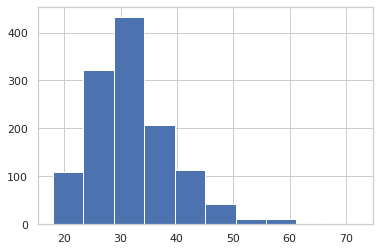

In [571]:
#produced univariate visuals for the target and all features

df['Age'].hist();


Average ages: late 20s to mid-30s

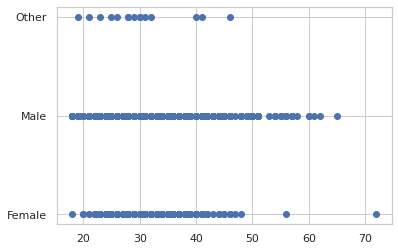

In [572]:

plt.scatter(df['Age'], df['Gender'])

Age vs Gender, we see that there are males of all ages, most of the females are under 48 except for a couple outliers, and all but three who are "other" are early thirties or younger. 

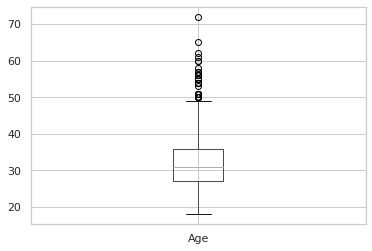

In [573]:
df.boxplot(column = 'Age');

Average age about 31; 75th percentil is about 36; "max" is under 50, but there are a number of outliers who are older.

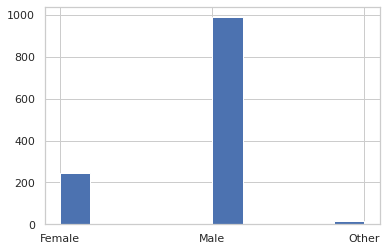

In [574]:
df['Gender'].hist();


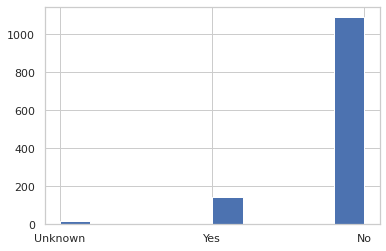

In [575]:
df['self_employed'].hist();

  

The large majority ar not self-employed; for those who are self-employed, the question about whether they are comfortable talking to their supervisor about mental health does not make sense. Luckily for our purposes, most are not self-employed.

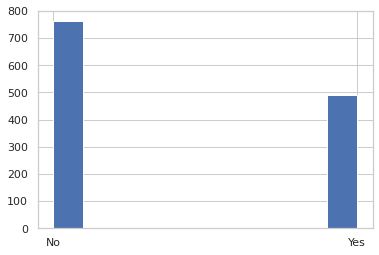

In [576]:
df['family_history'].hist();


Nearly two-thirds don't have a family history of mental health problems.

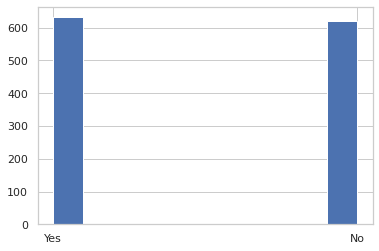

In [577]:
#treatment: Have you sought treatment for a mental health condition?

df['treatment'].hist()


About half of tech workers have sought treatment for mental health issues

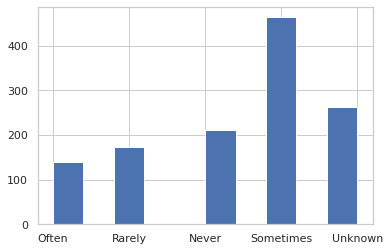

In [578]:
df['work_interfere'].hist()


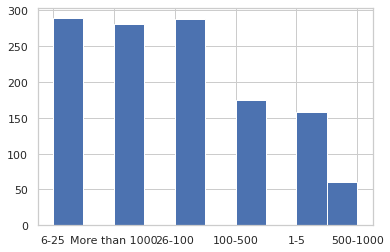

In [579]:
df['no_employees'].hist();


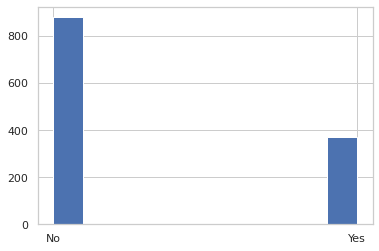

In [580]:
df['remote_work'].hist();


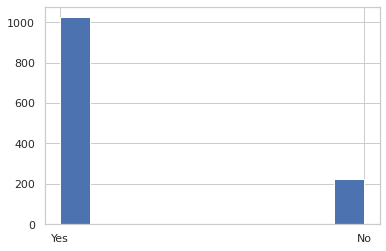

In [581]:
df['tech_company'].hist();


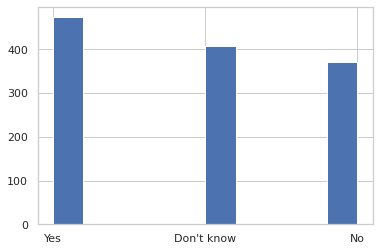

In [582]:
#benefits: Does your employer provide mental health benefits?


df['benefits'].hist();


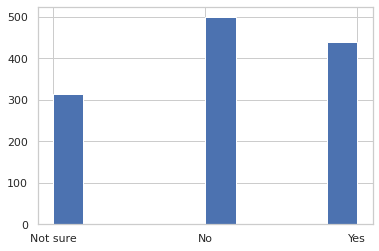

In [583]:
#care_options: Do you know the options for mental health care your employer provides?

df['care_options'].hist();


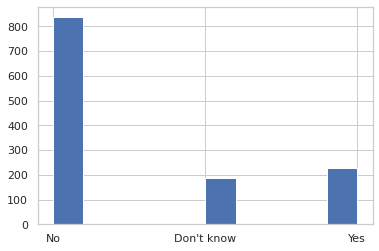

In [584]:
df['wellness_program'].hist();


The majority of companies don't have wellness programs

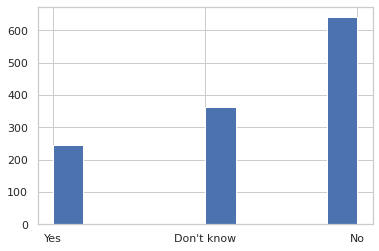

In [585]:
#seek_help: Does your employer provide resources to learn more about mental health issues and how to seek help?
df['seek_help'].hist();


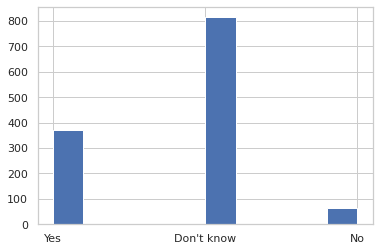

In [586]:
df['anonymity'].hist();


Most employees are unsure if they would have anonymity if they talked about mental health issues

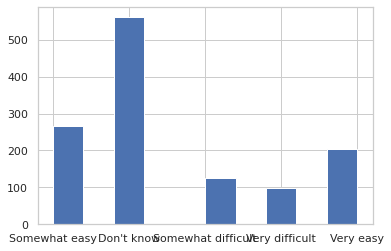

In [587]:
#How easy would it be to take leave for mental health reasons?
df['leave'].hist();


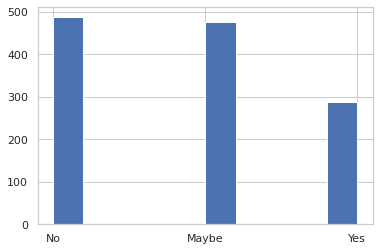

In [588]:
#Would discussing mental health issues with your employers have negative consequences?
df['mental_health_consequence'].hist();


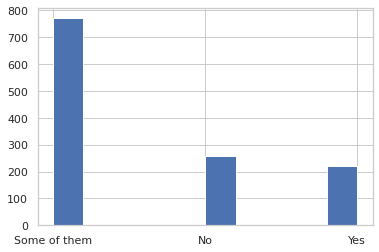

In [589]:
#Would you be comfortable sharing mental health issues with coworkers?
df['coworkers'].hist();


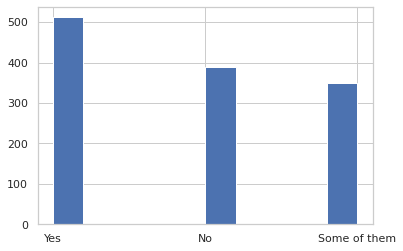

In [590]:
#Would you be comfortable sharing mental health issues with your superisor(s)?
#target variable
df['supervisor'].hist();


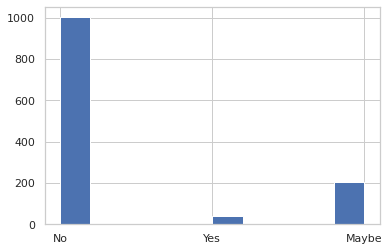

In [591]:
#Would you bring up mental health in an interview?
df['mental_health_interview'].hist();


Almost none are confident they would bring up mental health in an interview. 1000 say that they would not.

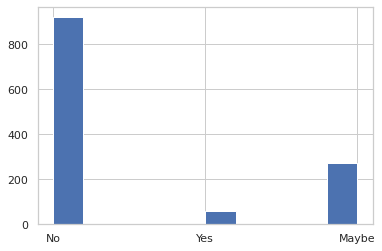

In [592]:
#Would discussing physical health issues with your employers have negative consequences?

df['phys_health_consequence'].hist();


While nearly 300 said "yes" to discussing mental health having negative consequences and nearly 500 said "maybe," when it comes to phyiscal health the chart above show that less than 100 think that such discussion would have negative repercussions, and nearly 1000 are confident that it would not.

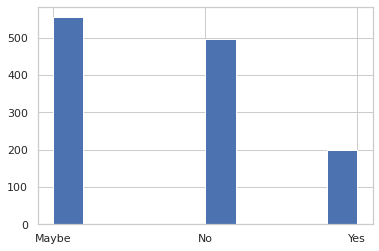

In [593]:
#Would you bring up physical health in an interview?
df['phys_health_interview'].hist();


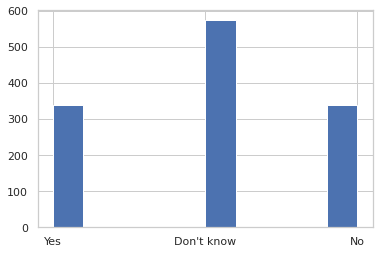

In [594]:
df['mental_vs_physical'].hist();


Pretty even split on whether employees take mental and phyiscal health as seriosuly as one another.

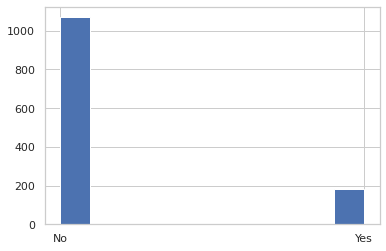

In [595]:
#Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?
df['obs_consequence'].hist();

Identified outliers:

There are very few self-employed people in this study. The majoirty of participants are male. Most participants are in their 30's, with some outliers in their 60s and 70s. Most of the participants work at tech companies. Most would not have anonymity if they talked about their mental health. Most of them did not have a mental health interview for their job.


Text(0.5, 1.0, 'Males least likely to seek treatment')

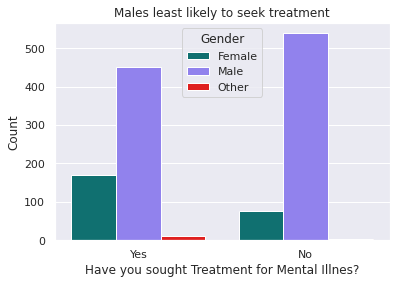

In [596]:
#Some multivariate analysis

sns.set_style('darkgrid')
colors = ['teal','#8470FF', 'red']
ax =sns.countplot(data = df, x = 'treatment',  hue = 'Gender', palette = colors)
plt.xlabel('Have you sought Treatment for Mental Illnes?')
plt.ylabel('Count')
plt.title('Males least likely to seek treatment')


(1) more males did not seek treatment than did, 
(2) more females DID seeks treatment than did not,
(3) ALL who classified as "other" sought treatment

Text(0.5, 1.0, 'Regardless of if they would talk to their supervisor, most would not mention it in an interview')

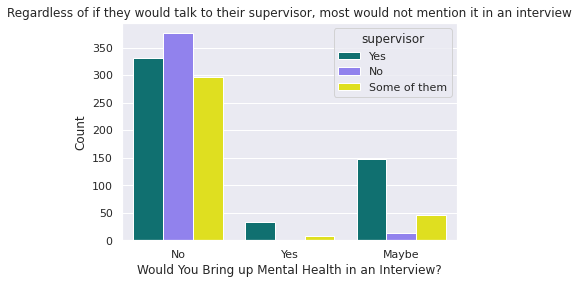

In [597]:
sns.set_style('darkgrid')
colors = ['teal','#8470FF', 'yellow']
ax =sns.countplot(data = df, x = 'mental_health_interview',  hue = 'supervisor', palette = colors)
plt.xlabel('Would You Bring up Mental Health in an Interview?')
plt.ylabel('Count')
plt.title('Regardless of if they would talk to their supervisor, most would not mention it in an interview')




(1)Relatively even split for those who would not bring it up in an interview- some would talk with a supervisor (600+) but 375 wouldn't talk to their supervisor

(2) those who would bring it up would talk to at least some supervisors

(3) those who might bring it up in an interview are highly likely to talk to some supervisors

Text(0.5, 1.0, '')

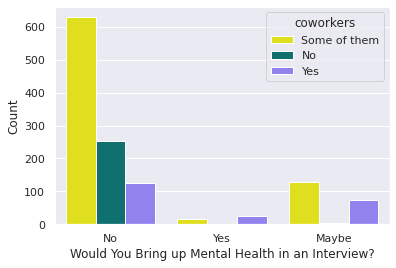

In [658]:
sns.set_style('darkgrid')
colors = ['yellow','teal','#8470FF']
ax =sns.countplot(data = df, x = 'mental_health_interview',  hue = 'coworkers', palette = colors)
plt.xlabel('Would You Bring up Mental Health in an Interview?')
plt.ylabel('Count')
plt.title('')

(1)Many who would not bring up mental health in an interview (600+) would, however, talk to at least soe coworkers

(2)Those who would bring it up in an interview unanimously would talk to at least some coworkers

(3)Those who migh also unanimously would talk to at least some coworkers

Text(0.5, 1.0, '')

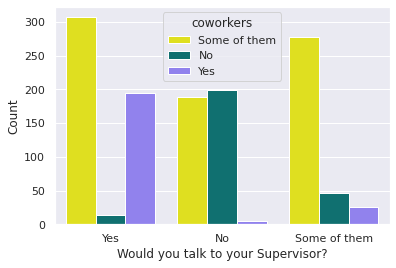

In [660]:
sns.set_style('darkgrid')
colors = ['yellow','teal','#8470FF']
ax =sns.countplot(data = df, x = 'supervisor',  hue = 'coworkers', palette = colors)
plt.xlabel('Would you talk to your Supervisor?')
plt.ylabel('Count')
plt.title('')

(1) Those who would talk to their supervisor, would also almost unanimously talk to at least some of their coworkers

(2)Those who wouldn't talk to their supervisor would not talk to their coworkers, or would only talk to some of them

(3)For the most part, those who would talk to some supervisors would also talk to some coworkers

Text(0.5, 1.0, '')

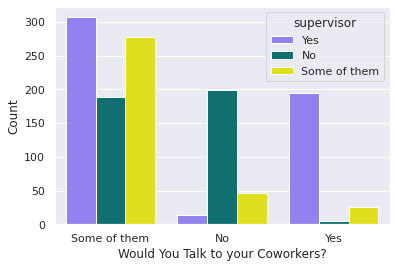

In [663]:
#This chart shows the same thing as the previous one, just coworker and supervisor being switched for bars and hues
sns.set_style('darkgrid')
colors = ['#8470FF', 'teal','yellow']
ax =sns.countplot(data = df, x = 'coworkers',  hue = 'supervisor', palette = colors)
plt.xlabel('Would You Talk to your Coworkers?')
plt.ylabel('Count')
plt.title('')

(1) Those who would talk to some coworkers are quite likely to also talk to their supervisor

(2) Those who would not talk to coworkers are very unlikely to talk to supervisors instead

(3)Those who talk responded "yes" rather than "some" to talking to Coworkers are most likely to also talk to a supervisor

Text(0.5, 1.0, '')

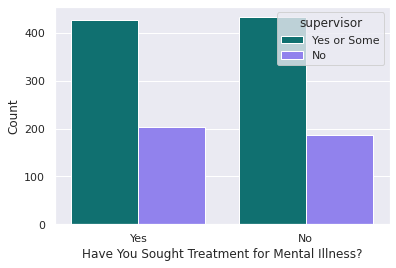

In [598]:
#Remapping the 'supervisor column allow us to see a different view of people's willingness to 
#talk to their supervisors by putting Yes and Some together
#I'll use the same stratgey for the Supervised Learning models, as our goal will be to see if they would talk to any of their supervisors
df['supervisor'] = df['supervisor'].map({'Yes': 'Yes or Some', 'Some of them': 'Yes or Some', 'No': 'No'})
sns.set_style('darkgrid')
colors = ['teal','#8470FF']
ax =sns.countplot(data = df, x = 'treatment',  hue = 'supervisor', palette = colors)
plt.xlabel('Have You Sought Treatment for Mental Illness?')
plt.ylabel('Count')
plt.title('')

This shows there is nearly a 50/50 split among those who have had treatment for mental illness and
those who would be comfortable talking to a supervisor about mental illness

That is, whether or not they're had issues with mental illness they're just as likely to not want to talk about it

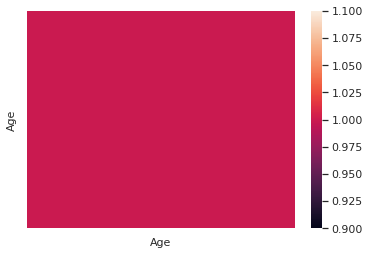

In [599]:
#produce a correlation heatmap and identify any moderate or strong correlations 
#between your target and your features and/or between one feature and anothe
corr=df.corr()
sns.heatmap(corr) 

A heatmap is pointless because I only have one numerical feature.

In [600]:
#One last tweak before starting Supervised Machine Learning: 
#since the target is to predict whether or not they are comfortable sharing with their supervisor, 
#When I encode the responses in numbers I will combine responses for "Yes" and "Some of them"
df['supervisor'] = df['supervisor'].map({'Yes or Some': 1, 'No': 0})


In [601]:
#OHE all of my categorical features
dummies_df = pd.get_dummies(df, columns=["Gender",
                                 'self_employed',
                                 'family_history',
                                 'treatment',
                                 'no_employees',
                                 'remote_work',
                                 'tech_company',
                                 'benefits',
                                 'care_options',
                                 'wellness_program',
                                 'seek_help',
                                 'anonymity',
                                 'leave',
                                 'mental_health_consequence',
                                 'work_interfere',
                                 'phys_health_consequence',
                                 'coworkers',
                                 'mental_health_interview',
                                 'phys_health_interview',
                                 'mental_vs_physical',
                                 'obs_consequence'] )

In [602]:
#Scale BEFORE doing PCA
scaler = StandardScaler()



In [603]:
#Creating target variable
y = df['supervisor']
X = dummies_df.drop(columns = 'supervisor')



In [604]:
#Checking out OHE dataframe for machine learning
X.head()

,Age,Gender_Female,Gender_Male,Gender_Other,self_employed_No,self_employed_Unknown,self_employed_Yes,family_history_No,family_history_Yes,treatment_No,treatment_Yes,no_employees_1-5,no_employees_100-500,no_employees_26-100,no_employees_500-1000,no_employees_6-25,no_employees_More than 1000,remote_work_No,remote_work_Yes,tech_company_No,tech_company_Yes,benefits_Don't know,benefits_No,benefits_Yes,care_options_No,care_options_Not sure,care_options_Yes,wellness_program_Don't know,wellness_program_No,wellness_program_Yes,seek_help_Don't know,seek_help_No,seek_help_Yes,anonymity_Don't know,anonymity_No,anonymity_Yes,leave_Don't know,leave_Somewhat difficult,leave_Somewhat easy,leave_Very difficult,leave_Very easy,mental_health_consequence_Maybe,mental_health_consequence_No,mental_health_consequence_Yes,work_interfere_Never,work_interfere_Often,work_interfere_Rarely,work_interfere_Sometimes,work_interfere_Unknown,phys_health_consequence_Maybe,phys_health_consequence_No,phys_health_consequence_Yes,coworkers_No,coworkers_Some of them,coworkers_Yes,mental_health_interview_Maybe,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_No,obs_consequence_Yes
0,37,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0
1,44,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0
2,32,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
3,31,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1
4,31,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0


In [605]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251 entries, 0 to 1258
Data columns (total 66 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Age                              1251 non-null   int64
 1   Gender_Female                    1251 non-null   uint8
 2   Gender_Male                      1251 non-null   uint8
 3   Gender_Other                     1251 non-null   uint8
 4   self_employed_No                 1251 non-null   uint8
 5   self_employed_Unknown            1251 non-null   uint8
 6   self_employed_Yes                1251 non-null   uint8
 7   family_history_No                1251 non-null   uint8
 8   family_history_Yes               1251 non-null   uint8
 9   treatment_No                     1251 non-null   uint8
 10  treatment_Yes                    1251 non-null   uint8
 11  no_employees_1-5                 1251 non-null   uint8
 12  no_employees_100-500             1251 non-null  

In [606]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


In [607]:
#Using PCA and a pipeline for Supervised Machine Learning
#I'll try for these models, but because the dataset is not too big it is likely to be unnecessary/unhelpful on most models
pca = PCA(n_components = .95) 

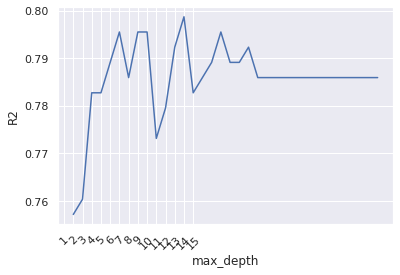

In [608]:

#looking for ideal max_depth for a RandomForestClassifier
max_depth_range_forest = list(range(2, 36)) 

r2 = []
for depth in max_depth_range_forest:
    rf = RandomForestClassifier(max_depth = depth, 
                             random_state = 42)
    rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)

    r2.append(score)
#Plot for depth for random forests model

plt.plot(max_depth_range_forest, r2)
sns.set(style="ticks")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], rotation =45)
sns.set_style('whitegrid')
plt.xlabel('max_depth')
plt.ylabel('R2');

Max depth of 14 is ideal

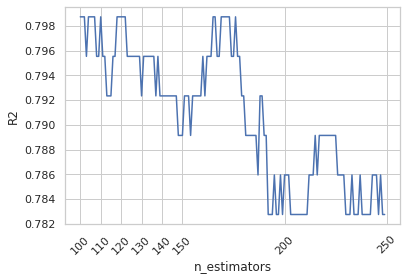

In [609]:
#looking for ideal n_estimators for a RandomForestClassifier

n_estimators_rf = list(range(100, 250)) 

r2 = []
for estimators in n_estimators_rf:
    rf = RandomForestClassifier(max_depth = 14, n_estimators = estimators, 
                             random_state = 42)
    rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    r2.append(score)
plt.plot(n_estimators_rf, r2)
sns.set(style="ticks")
plt.xticks([100,110,120,130,140,150,200,250], rotation = 45)
sns.set_style('whitegrid')
plt.xlabel('n_estimators')
plt.ylabel('R2');

In [610]:
#instantiate with hyperparameters based on the above exploratory code
rf = RandomForestClassifier(max_depth =14, random_state =42, n_estimators = 100)


In [611]:
#with PCA
pipe = make_pipeline(scaler, pca, rf)
pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

1.0
0.7635782747603834


In [612]:
#without PCA
pipe = make_pipeline(scaler, rf)
pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

0.9989339019189766
0.8019169329073482


In [613]:
#instantiating and fitting next model
bt = BaggingClassifier()



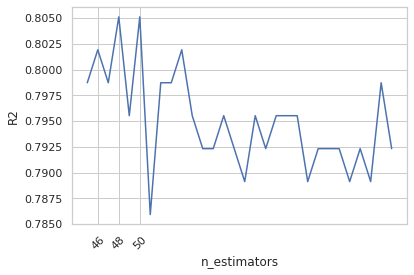

In [614]:
#Lookinh for ideal number of estimators
estimators_bt = list(range(45, 75)) 

r2 = []
for estimators in estimators_bt:
    bt = BaggingClassifier(n_estimators = estimators, 
                             random_state = 42)
    bt.fit(X_train, y_train)
    score = bt.score(X_test, y_test)
    r2.append(score)
plt.plot(estimators_bt, r2)
sns.set(style="ticks")
plt.xticks([46,48,50], rotation =45)
sns.set_style('whitegrid')
plt.xlabel('n_estimators')
plt.ylabel('R2');

48 or 50 will work the best. I'll choose 48 because it means less iterations.

In [615]:
#using hyperparemeter from above exploration
bt = BaggingClassifier(n_estimators =48,  random_state = 42)
pipe_bt  = make_pipeline(scaler,bt)
pipe_bt.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=None, bootstrap=True,
                                   bootstrap_features=False, max_features=1.0,
                                   max_samples=1.0, n_estimators=48,
                                   n_jobs=None, oob_score=False,
                                   random_state=42, verbose=0,
                                   warm_start=False))],
         verbose=False)

In [616]:
print(pipe_bt.score(X_train, y_train))
print(pipe_bt.score(X_test, y_test))

1.0
0.805111821086262


Second highest r^2

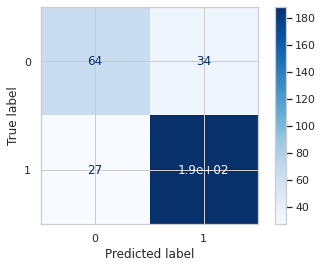

In [617]:
#Checking what type of misclassifications the model made
plot_confusion_matrix(pipe_bt, X_test, y_test, cmap = 'Blues');

In [618]:
#instantiating and fitting next model

lgb = LGBMClassifier()

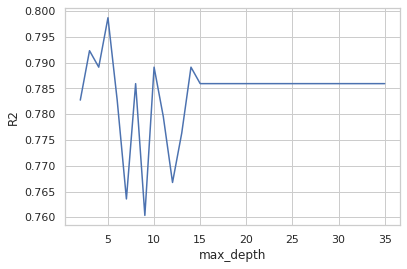

In [619]:
#looking for ideal max_depth
max_depth_range_lgb = list(range(2, 36)) 

r2 = []
for depth in max_depth_range_forest:
    lgb = LGBMClassifier(max_depth = depth, 
                             random_state = 42)
    lgb.fit(X_train, y_train)
    score = lgb.score(X_test, y_test)
    r2.append(score)
plt.plot(max_depth_range_lgb, r2)
sns.set(style="ticks")
#plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
sns.set_style('whitegrid')
plt.xlabel('max_depth')
plt.ylabel('R2');

In [620]:
lgb = LGBMClassifier(max_depth = 5, random_state = 42)
pipe_lgb  = make_pipeline(scaler,lgb)
pipe_lgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lgbmclassifier',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=5,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None, random_state=42,
                                reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                subsample=1.0, subsample_for_bin=200000,
                                subsample_freq=0))],
         verbose=False)

In [621]:
print(pipe_lgb.score(X_train, y_train))
print(pipe_lgb.score(X_test, y_test))

0.9584221748400853
0.7987220447284346


In [622]:
lgb = LGBMClassifier(max_depth = 4, n_estimators = 50, num_leaves =10, random_state = 42)
pipe_lgb  = make_pipeline(scaler,lgb)
pipe_lgb.fit(X_train, y_train)
print(pipe_lgb.score(X_train, y_train))
print(pipe_lgb.score(X_test, y_test))

0.8720682302771855
0.8083067092651757


Supposedly 5 is the ideal max_depth, but 4 returns a better r^2 with other tuned hyperparameters

Highest r^2

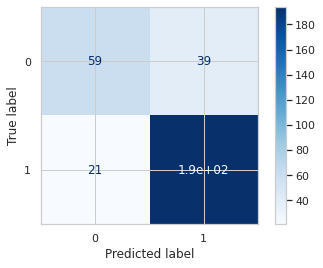

In [623]:
plot_confusion_matrix(pipe_lgb, X_test, y_test, cmap = 'Blues');

In [624]:
#Gridsearch for Light Gradient Booster
lgb_params = {'lgbmclassifier__num_estimators' : [50,100,150,200,250], 
          'lgbmclassifier__num_leaves' : [5,10,15,20,25,29,30,31,35,40], 
          'lgbmclassifier__max_depth' : [1,2,3,4,5,10,15,20,25]
          }
grid_lgb = GridSearchCV(pipe_lgb, lgb_params)
grid_lgb.fit(X_train, y_train)
grid_lgb.best_params_
grid_lgb.score(X_train, y_train)
grid_lgb.score(X_test, y_test)


0.8083067092651757

Highest r^2 overall; the same model as pipe_lgb

In [625]:
#instantiate and fit next model
log_reg = LogisticRegression(random_state = 42)
pipe_log_reg  = make_pipeline(scaler,pca,log_reg)
pipe_log_reg.fit(X_train, y_train)
print(pipe_log_reg.score(X_train, y_train))
print(pipe_log_reg.score(X_test, y_test))

0.8336886993603412
0.7827476038338658


In [626]:
log_reg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Not any critical hyperparameters to tune

In [627]:
#Instantiate and fit next model
xgb = XGBClassifier(max_depth =4, n_estimators =150, random_state = 42)
pipe_xgb  = make_pipeline(scaler,xgb)
pipe_xgb.fit(X_train, y_train)

print(pipe_xgb.score(X_train, y_train))
print(pipe_xgb.score(X_test, y_test))

0.9573560767590619
0.792332268370607


In [628]:
#I'm not going to run GridSearchCV on this model because it takes forever 
#so I'll manually try some different params
xgb = XGBClassifier(max_depth =4, n_estimators =75, random_state = 42)
pipe_xgb  = make_pipeline(scaler,xgb)
pipe_xgb.fit(X_train, y_train)

print(pipe_xgb.score(X_train, y_train))
print(pipe_xgb.score(X_test, y_test))

0.9008528784648188
0.8019169329073482


^^The highest r^2 for XGB; 2nd highest among all the models

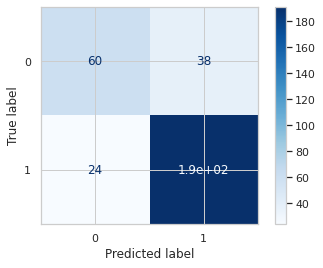

In [629]:
plot_confusion_matrix(pipe_xgb, X_test, y_test, cmap = 'Blues');

In [630]:
#different hyperparameters tried on xgb
xgb = XGBClassifier(max_depth =5, n_estimators =75, random_state = 42)
pipe_xgb  = make_pipeline(scaler,xgb)
pipe_xgb.fit(X_train, y_train)

print(pipe_xgb.score(X_train, y_train))
print(pipe_xgb.score(X_test, y_test))

0.9434968017057569
0.7859424920127795


In [631]:
#different hyperparameters tried on xgb

xgb = XGBClassifier(max_depth =3, n_estimators =150, random_state = 42)
pipe_xgb  = make_pipeline(scaler,xgb)
pipe_xgb.fit(X_train, y_train)

print(pipe_xgb.score(X_train, y_train))
print(pipe_xgb.score(X_test, y_test))

0.9051172707889126
0.7987220447284346


In [632]:
#instantiate next model
gb = GradientBoostingClassifier(random_state = 42)
pipe_gb  = make_pipeline(scaler,pca,gb)
pipe_gb.fit(X_train, y_train)
print(pipe_gb.score(X_train, y_train))
print(pipe_gb.score(X_test, y_test))

0.9733475479744137
0.7891373801916933


In [633]:
#not going to GridSearchCV on this either for the same reason
gb = GradientBoostingClassifier(max_depth = 4, n_estimators = 150, max_features = 15, random_state = 42)
pipe_gb  = make_pipeline(scaler,pca,gb)
pipe_gb.fit(X_train, y_train)
print(pipe_gb.score(X_train, y_train))
print(pipe_gb.score(X_test, y_test))

1.0
0.7891373801916933


In [634]:
#different hyperparameters tried on gb

gb = GradientBoostingClassifier(max_depth = 4, n_estimators = 150, random_state = 42)
pipe_gb  = make_pipeline(scaler,pca,gb)
pipe_gb.fit(X_train, y_train)
print(pipe_gb.score(X_train, y_train))
print(pipe_gb.score(X_test, y_test))

1.0
0.7603833865814696


In [635]:
#different hyperparameters tried on gb

gb = GradientBoostingClassifier(max_depth = 4, n_estimators = 75, max_features = 24, random_state = 42)
pipe_gb  = make_pipeline(scaler,pca,gb)
pipe_gb.fit(X_train, y_train)
print(pipe_gb.score(X_train, y_train))
print(pipe_gb.score(X_test, y_test))

0.997867803837953
0.7731629392971247


In [636]:
#different hyperparameters tried on gb

gb = GradientBoostingClassifier(max_depth = 2, n_estimators = 200,  random_state = 42)
pipe_gb  = make_pipeline(scaler,pca,gb)
pipe_gb.fit(X_train, y_train)
print(pipe_gb.score(X_train, y_train))
print(pipe_gb.score(X_test, y_test))

0.9530916844349681
0.7859424920127795


None of the hyperparemeter tuning i tried on GradientBoostingClassifier made any improvement on the default parameters

In [637]:
#Instantiate next model
knn = KNeighborsClassifier()
pipe_knn  = make_pipeline(scaler,pca,knn)
pipe_knn.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

In [638]:
print(pipe_knn.score(X_train, y_train))
print(pipe_knn.score(X_test, y_test))


0.8315565031982942
0.7667731629392971


In [639]:
#GridSearch for ideal parameters
knn_params = {'kneighborsclassifier__n_neighbors' : [2, 5, 10, 50, 100],
          'kneighborsclassifier__weights' : ['uniform', 'distance'], 
          'kneighborsclassifier__algorithm' : ['auto', 'ball_tree'], 
          'kneighborsclassifier__p' : [1,2]}
grid_knn =GridSearchCV(pipe_knn, knn_params)
grid_knn.fit(X_train, y_train)
grid_knn.best_params_

{'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__n_neighbors': 50,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'distance'}

In [640]:
grid_knn.score(X_train, y_train)
grid_knn.score(X_test, y_test)

0.7859424920127795

In [641]:
knn = KNeighborsClassifier(algorithm = 'auto',
 n_neighbors = 50,
 p = 2,
 weights = 'distance')
pipe_knn  = make_pipeline(scaler,pca,knn)
pipe_knn.fit(X_train, y_train)
print(pipe_knn.score(X_train, y_train))
print(pipe_knn.score(X_test, y_test))

1.0
0.7859424920127795


The best models I got are light gradient booster, bagged trees, and XGBoost (in that order) at around 80% each.

I am choosing the LGBMClassifier (light gradient booster) as my "production model" because it has the highest r^2 score.

THIS NEXT SECTION IS FOR UNSUPERVISED LEARNING CLUSTERING MODELS— KMEANS CLUSTERING, HIERARCHICAL (AGGLOMERATIVE) CLUSTERING, AND DBSCAN CLUSTERING. I WILL EVALUATE EACH CLUSTERING METHOD USING SILHOUTTE_SCORE

In [642]:
#Creating the dataframe to be used for unsupervised learning
scaled_np = scaler.fit_transform(dummies_df)
scaled_df = pd.DataFrame(scaled_np)
scaled_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66
0,0.675775,0.673024,2.016129,-1.942887,-0.110163,-2.611274,8.276473,-0.357831,0.801082,-0.801082,-0.989662,0.989662,-0.380206,-0.403286,-0.546869,-0.22445,1.824478,-0.538229,0.649300,-0.649300,-0.469561,0.469561,-0.694426,-0.649300,1.282505,-0.814594,1.731128,-0.735283,-0.419228,0.703295,-0.470829,-0.639362,-1.025095,2.016129,-1.367211,-0.232201,1.537174,-0.901689,-0.333185,1.928926,-0.289923,-0.440116,-0.783705,1.252513,-0.546869,-0.451710,2.817040,-0.400603,-0.767842,-0.514698,-0.528338,0.599819,-0.220492,-0.509724,0.789030,-0.464482,-0.445282,0.497251,-0.184077,1.119846,-0.810527,-0.436228,-0.920792,-0.608447,1.640203,0.411289,-0.411289
1,1.636606,-1.485831,-0.496000,0.514698,-0.110163,-2.611274,8.276473,-0.357831,0.801082,-0.801082,1.010446,-1.010446,-0.380206,-0.403286,-0.546869,-0.22445,-0.548102,1.857944,0.649300,-0.649300,2.129647,-2.129647,1.440038,-0.649300,-0.779724,1.227605,-0.577658,-0.735283,2.385338,-1.421879,-0.470829,1.564059,-1.025095,-0.496000,0.731416,-0.232201,-0.650545,1.109030,-0.333185,-0.518423,-0.289923,-0.440116,1.275990,-0.798395,-0.546869,-0.451710,-0.354983,2.496240,-0.767842,-0.514698,-0.528338,0.599819,-0.220492,1.961845,-1.267379,-0.464482,-0.445282,0.497251,-0.184077,-0.892980,1.233766,-0.436228,1.086021,-0.608447,-0.609681,0.411289,-0.411289
2,-0.010533,0.673024,-0.496000,0.514698,-0.110163,-2.611274,8.276473,-0.357831,0.801082,-0.801082,1.010446,-1.010446,-0.380206,-0.403286,-0.546869,-0.22445,1.824478,-0.538229,0.649300,-0.649300,-0.469561,0.469561,-0.694426,1.540119,-0.779724,1.227605,-0.577658,-0.735283,-0.419228,0.703295,-0.470829,-0.639362,0.975519,-0.496000,0.731416,-0.232201,-0.650545,-0.901689,3.001333,-0.518423,-0.289923,-0.440116,-0.783705,1.252513,-0.546869,-0.451710,-0.354983,2.496240,-0.767842,-0.514698,-0.528338,0.599819,-0.220492,-0.509724,-1.267379,2.152936,-0.445282,-2.011058,5.432513,-0.892980,-0.810527,2.292379,-0.920792,1.643528,-0.609681,0.411289,-0.411289
3,-0.147795,-1.485831,-0.496000,0.514698,-0.110163,-2.611274,8.276473,-0.357831,-1.248312,1.248312,-0.989662,0.989662,-0.380206,-0.403286,1.828592,-0.22445,-0.548102,-0.538229,0.649300,-0.649300,-0.469561,0.469561,-0.694426,1.540119,-0.779724,-0.814594,-0.577658,1.360021,-0.419228,0.703295,-0.470829,-0.639362,0.975519,-0.496000,-1.367211,4.306608,-0.650545,-0.901689,3.001333,-0.518423,-0.289923,-0.440116,-0.783705,-0.798395,1.828592,-0.451710,2.817040,-0.400603,-0.767842,-0.514698,-0.528338,-1.667170,4.535302,-0.509724,0.789030,-0.464482,2.245769,-2.011058,-0.184077,1.119846,-0.810527,-0.436228,-0.920792,1.643528,-0.609681,-2.431379,2.431379
4,-0.147795,0.673024,-0.496000,0.514698,-0.110163,-2.611274,8.276473,-0.357831,0.801082,-0.801082,1.010446,-1.010446,-0.380206,2.479631,-0.546869,-0.22445,-0.548102,-0.538229,-1.540119,1.540119,-0.469561,0.469561,-0.694426,-0.649300,1.282505,1.227605,-0.577658,-0.735283,2.385338,-1.421879,-0.470829,1.564059,-1.025095,-0.496000,0.731416,-0.232201,-0.650545,1.109030,-0.333185,-0.518423,-0.289923,-0.440116,-0.783705,1.252513,-0.546869,2.213807,-0.354983,-0.400603,-0.767842,-0.514698,-0.528338,0.599819,-0.220492,-0.509724,0.789030,-0.464482,-0.445282,-2.011058,5.432513,-0.892980,-0.810527,2.292379,1.086021,-0.608447,-0.609681,0.411289,-0.411289


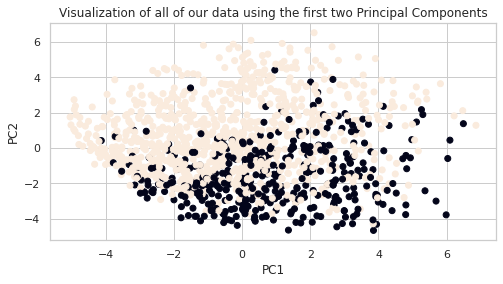

In [643]:
#PCA for data visualization
le = LabelEncoder()
y_pca_dv = le.fit_transform(df['supervisor'])
pca = PCA(n_components=2)
pcs = pca.fit_transform(scaled_df)

#visualize it
plt.figure(figsize = (8, 4))
plt.scatter(pcs[:,0], pcs[:,1], c = y_pca_dv)
plt.title('Visualization of all of our data using the first two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2');



We can see here that there is some separation between the two groups (which people would and would not talk to a supervisor about mental health), but also significant overlap in the middle. The clearest section is upper-left where there is mostly white and nearly no black.

This also gives some explanation as to why the supervised learning models' r^2's were not perfect, since there is some significant overlap in the two groups.

In [644]:
#DBSCAN

dbs = DBSCAN( eps = 0.5, min_samples = -1).fit(scaled_df)
scaled_df['cluster_db'] = dbs.labels_
silhouette_score(scaled_df, dbs.labels_)


0.006394884092725819

Obviously not a good dataset for DBSCAN. Very terrible score. Probably ends up with far too many groups.

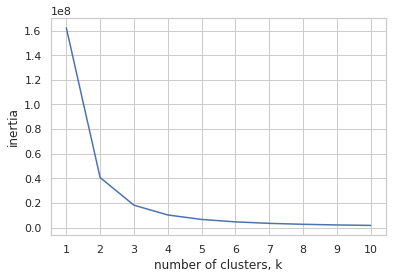

In [645]:
#KMeans elbow plot to find ideal number of clusters
ks = range(1,11)
inertias = []
for k in ks:
        model = KMeans(n_clusters=k)
        model.fit(scaled_df)
        inertias.append(model.inertia_)
plt.plot(ks, inertias)
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

The "elbow" is at two, suggesting 2 to be the ideal number of clusters

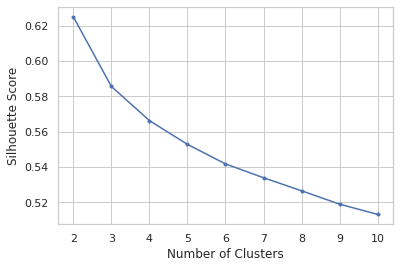

In [646]:
#Silhoutte score graph KMeans


silhouette_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(scaled_df)
  silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

Looks like ideal number of clusters is 2 or 3

In [647]:
#trying silhoutte scores for both 2 and 3 clusters to see what gets the best score
kmeans_2 = KMeans(n_clusters = 2)
kmeans_3 = KMeans(n_clusters = 3)

kmeans_2.fit(scaled_df)
kmeans_3.fit(scaled_df)

scaled_df['cluster_km2'] = kmeans_2.labels_
scaled_df['cluster_km3'] = kmeans_3.labels_
silhouette_score(scaled_df, kmeans.labels_)



0.5131908238269463

In [648]:
silhouette_score(scaled_df, kmeans_2.labels_)


0.6250762895707275

^Two clusters gives highest silhoutte score for KMeans

In [649]:
silhouette_score(scaled_df, kmeans_3.labels_)


0.5856573738863099

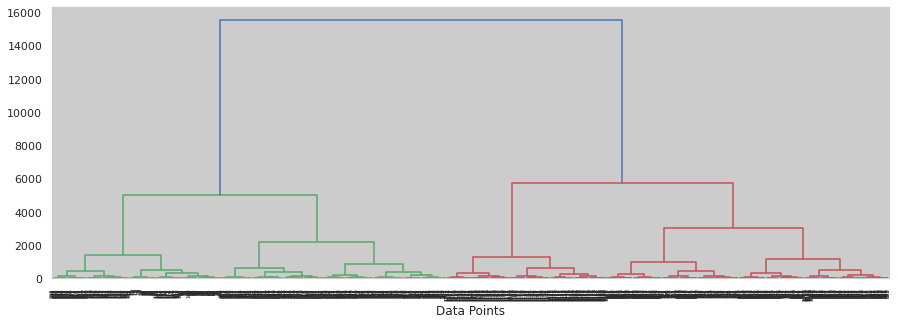

In [650]:
#Hierarchical clustering
plt.figure(figsize = (15, 5))
sch.dendrogram(sch.linkage(scaled_df, method = 'ward'))
plt.xlabel('Data Points');

Most likely based on this 2,4, or 8 clusters might be best. We'll try all of them.


In [651]:
#prepping to get silhoutte scores for 2,4, and 8 clusters
hc_2 = AgglomerativeClustering(n_clusters = 2)
hc_4 = AgglomerativeClustering(n_clusters = 4)
hc_8 = AgglomerativeClustering(n_clusters = 8)

hc_2.fit(scaled_df)
hc_4.fit(scaled_df)
hc_8.fit(scaled_df)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=8)

In [652]:
scaled_df['cluster_h3'] = hc_2.labels_
scaled_df['cluster_h4'] = hc_4.labels_
scaled_df['cluster_h5'] = hc_8.labels_


In [653]:
silhouette_score(scaled_df, hc_2.labels_)


0.6232000413019344

Two clusters also gives the highest silhoutte score for hierarchical clustering. It is only a fraction of a percent lower than the score from the KMeans 2-cluster.

In [654]:
silhouette_score(scaled_df, hc_4.labels_)


0.5346112659218875

In [655]:
silhouette_score(scaled_df, hc_8.labels_)


0.4966038053052723

Using two clusters for either KMeans or Agglomerative clustering gives the best result.


TAKEAWAYS:

A highly accurate prediction (80%) can be made based on the data from this dataset whether or not an employee is likely to be willing to talk to their supervisor about mental health.

Based on data visualizations, a number of insights can be gleaned concerning the feelings and practices surrounding mental health for tech workers

-33% of respondents have a family history of mental health

-50% have sought treatment for mental health

-33% would not be comfortable talking to a supervisor about mental health

-An overwhelming majority (83%) would not bring up mental health in an interview and 66% think it would or might have negative effects if they were to have a discussion about mental health with their employer. 

-Men are less likely to have gotten treatment for mental illness

-The vast majority of employees (1000+) would not mention mental illness in an interview, but many would be open to talking about it with a supervisor (600+)

-Many who would not talk to a supervisor would talk to a coworker

-Whether or not a person feels comfortable talking to a supervisor is not correlated to whether or not they have been treated for mental illness. Although not visualized in this project, the same is true about talking to coworkers, so we can expand to say that whether a person feels comfortable talking about mental health at work is not correlated to whether or not they have been treated for mental illness.

Despite half of the respondents having had mental health issues serious enough for professional care, a substantial amount of respondents feel uncomfortable talking about mental illness, or feel that talking about their own mental health could have negative consequences.

Ideas for improving company culture around mental health care, aiming for (1) more employees to think their employers take mental health seriously and (2) Support those with mental health issues.

-Employers/supervisors opening conversations about health care so that employees feel that the topic is safe.

-Coworker support structures(Since many who would not feel comfortable talking to a supervisor would talk to a coworker); what might this look like?

-Companies providing wellness programs and mental health care, such as insurance covering counseling.

-Advertising the company's options for mental health care (many respondents were not aware of the options)

